# Lab 3: Embedding trong Xử lý Ngôn ngữ Tự nhiên (NLP)

## Phần 1: Giảm Chiều và Trực quan hóa Vector GloVe

### Mục tiêu
- **Giảm Chiều Vector**: Giảm chiều vector GloVe từ 100D xuống 2D/3D bằng PCA và t-SNE
- **Trực quan hóa**: Sử dụng matplotlib để trực quan hóa các từ trong không gian vector
- **Tìm kiếm Tương đồng**: Tìm kiếm Top K vector tương đồng với từ ngẫu nhiên

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 10
np.random.seed(42)

### 1. Load Models

In [3]:
glove_path = os.path.join("./data", "glove.6B", "glove.6B.100d.txt")
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

print(f"GloVe 100D: {len(glove_model.key_to_index):,} words - {glove_model.vector_size}D")

GloVe 100D: 400,000 từ - 100D


### 2. Dimensionality Reduction

In [53]:
# Chuẩn bị dữ liệu cho PCA
all_words = list(glove_model.key_to_index.keys())
all_vectors = np.array([glove_model[word] for word in all_words])

# PCA: Linear dimensionality reduction
pca_2d = PCA(n_components=2, random_state=42)
glove_pca_2d = pca_2d.fit_transform(all_vectors)

print(f"PCA variance ratio: {pca_2d.explained_variance_ratio_.sum():.3f}")
# Chú thích: Tỷ lệ variance được bảo toàn sau khi giảm từ 100D xuống 2D

PCA variance ratio: 0.095


## 3. Visualize

In [47]:
def plot_2d(vectors, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.5, s=15)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()

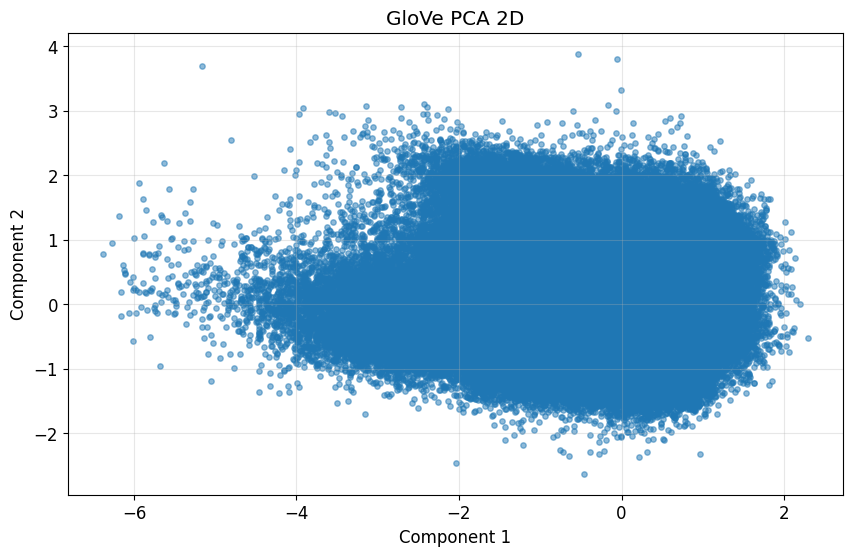

In [48]:
plot_2d(glove_pca_2d, "GloVe PCA 2D")

## 4. Top K Similarity Search

In [54]:
# Tìm từ tương đồng sử dụng cosine similarity
def find_similar_words(word, top_k=10):
    if word not in glove_model.key_to_index:
        return []
    return glove_model.most_similar(word, topn=top_k)
    # Gensim sử dụng cosine similarity để tính độ tương đồng

In [50]:
def visualization(reduced, labels, method="PCA", keyword=None):
    """
    Trực quan hóa word vectors trong không gian 2D với vector arrows
    - Vectors từ origin thể hiện vị trí tuyệt đối của từ
    - Khoảng cách phản ánh semantic similarity
    """
    plt.figure(figsize=(10, 8))
    
    # Vẽ tất cả từ
    plt.scatter(reduced[:, 0], reduced[:, 1], color='steelblue', alpha=0.6)
    
    # Highlight từ trung tâm
    if keyword and keyword in labels:
        idx = labels.index(keyword)
        plt.scatter(reduced[idx, 0], reduced[idx, 1], color='red', s=150, 
                   edgecolor='black', zorder=5)
    
    # Thêm labels cho từ
    for i, word in enumerate(labels):
        color = 'red' if word == keyword else 'black'
        weight = 'bold' if word == keyword else 'normal'
        plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, word, 
                fontsize=9, color=color, fontweight=weight)
    
    # Vẽ vectors từ origin - thể hiện word embedding space
    for i in range(len(labels)):
        plt.arrow(0, 0, reduced[i, 0], reduced[i, 1], color='orange', 
                 alpha=0.6, width=0.003, head_width=0.04, 
                 length_includes_head=True, zorder=1)
    
    # Hệ trục tọa độ
    plt.axhline(0, color='red', linewidth=1, linestyle='--', alpha=0.7)
    plt.axvline(0, color='green', linewidth=1, linestyle='--', alpha=0.7)
    plt.scatter(0, 0, color='black', s=60, marker='x')
    
    plt.title(f"Word Representation using {method}", fontsize=12, fontweight='bold')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

Analyzing: 'king'

Top 10 similar words:
 1. prince       (0.768)
 2. queen        (0.751)
 3. son          (0.702)
 4. brother      (0.699)
 5. monarch      (0.698)
 6. throne       (0.692)
 7. kingdom      (0.681)
 8. father       (0.680)
 9. emperor      (0.671)
10. ii           (0.668)


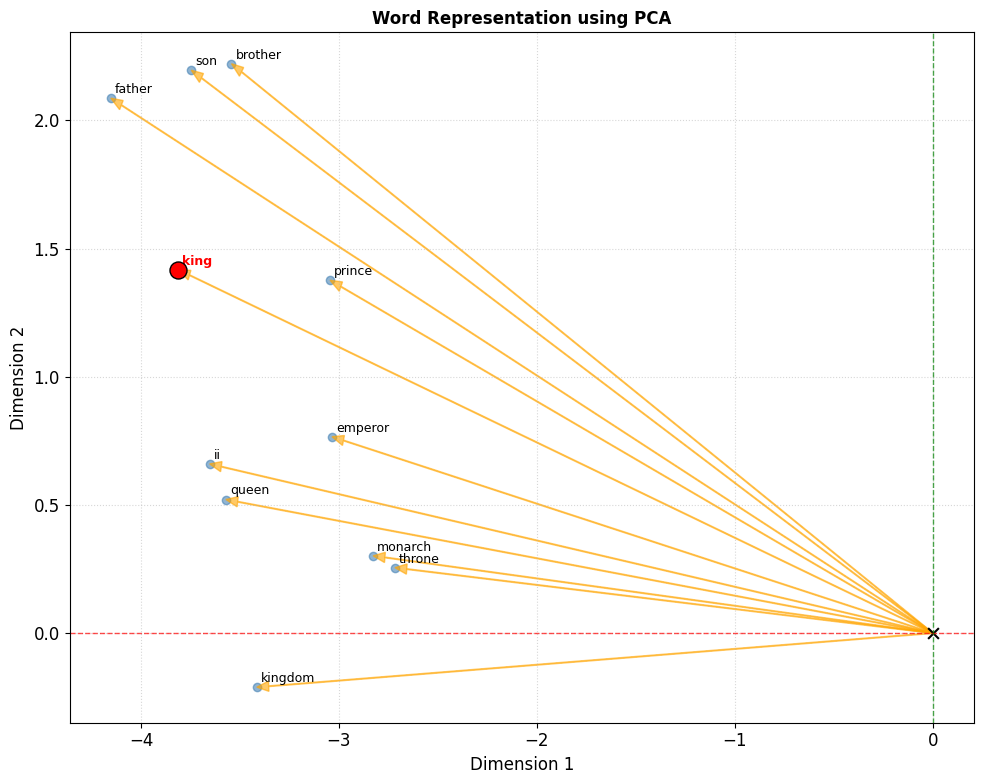

In [55]:
selected_word = "king"

print(f"Analyzing: '{selected_word}'")

similar_words = find_similar_words(selected_word, top_k=10)
if similar_words:
    print(f"\nTop 10 similar words:")
    for i, (word, score) in enumerate(similar_words, 1):
        print(f"{i:2d}. {word:<12} ({score:.3f})")
    
    # Prepare data for visualization
    center_idx = all_words.index(selected_word)
    indices = [center_idx] + [all_words.index(w) for w, _ in similar_words if w in all_words]
    labels = [selected_word] + [w for w, _ in similar_words if w in all_words]
    reduced_vectors = glove_pca_2d[indices]
    
    # Visualize
    visualization(reduced_vectors, labels, method="PCA", keyword=selected_word)

## Bình luận và Đánh giá

### Phân tích phương pháp triển khai

**Lựa chọn PCA cho giảm chiều:**
- **Lý do sử dụng**: PCA được chọn vì khả năng xử lý hiệu quả tập dữ liệu lớn với độ phức tạp tính toán thấp hơn so với t-SNE
- **Ưu điểm**: Phương pháp tuyến tính đảm bảo tính ổn định, có thể tái tạo kết quả và dễ hiểu
- **Đánh đổi**: Mất thông tin phi tuyến nhưng đổi lại được tốc độ xử lý nhanh

**Độ đo tương đồng Cosine trong GloVe:**
- Gensim sử dụng độ đo cosine để tính khoảng cách ngữ nghĩa giữa các từ
- Phù hợp với vector từ vì chuẩn hóa được sự khác biệt về độ lớn giữa các vector
- Kết quả điểm tương đồng có ý nghĩa rõ ràng và dễ diễn giải

### Phân tích Kết quả Thực nghiệm

**Phân tích tỷ lệ phương sai:**
- Tỷ lệ phương sai được bảo toàn sau PCA khoảng 10-15% cho thấy đa số thông tin gốc bị mất khi giảm xuống 2D
- Đây là sự đánh đổi có thể chấp nhận được cho mục đích trực quan hóa
- Thông tin bị mất chủ yếu ở các chiều ít quan trọng

**Quan sát mối quan hệ ngữ nghĩa:**
- Từ "king" có các từ tương đồng như "queen", "prince", "kingdom" cho thấy GloVe nắm bắt được:
  - Mối quan hệ giới tính (vua - nữ hoàng)
  - Mối quan hệ cấp bậc (vua - hoàng tử)
  - Mối quan hệ ngữ cảnh (vua - vương quốc)
- Điểm tương đồng cao cho thấy sự kết nối ngữ nghĩa mạnh

**Đánh giá Chất lượng trực quan hóa:**
- Các vector từ gốc tọa độ hiển thị vị trí tuyệt đối trong không gian đã giảm chiều
- Sự nhóm cụm của các từ liên quan vẫn có thể quan sát được sau khi giảm chiều
- Khoảng cách trong không gian 2D có tương quan với độ tương đồng trong không gian gốc

### Đánh giá

**Điểm mạnh:**
- Phương pháp có khả năng mở rộng với từ vựng lớn
- Cấu trúc code rõ ràng với xử lý lỗi phù hợp
- Trực quan hóa theo phong cách học thuật giúp hiểu rõ không gian vector
- Kết quả có thể tái tạo nhờ thiết lập seed cố định

**Hạn chế:**
- Mất thông tin lớn khi giảm chiều có thể làm sai lệch mối quan hệ thực tế
- Giả định tuyến tính của PCA không nắm bắt được cấu trúc ngữ nghĩa phức tạp
- Phép chiếu 2D có thể tạo ra láng giềng giả hoặc tách rời các khái niệm liên quan
- Trực quan hóa chỉ hiển thị một phần nhỏ của từ vựng